# Modelo Definitivo para IDH

In [ ]:
!pip install plotly

In [19]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Carregar o arquivo CSV
file_path = 'C:\\DSA_USP\\DATA_SOURCE\\ANÁLISE FINAL V05.csv'
df = pd.read_csv(file_path, sep=';', decimal=',')

#----------------------------------------------------------------------------------------
# Excluir as observações de variáveis com missing values (null e NA)
df.replace(to_replace=["null", "NULL", np.nan], value="", inplace=True)
dados = df.dropna()

# Total de observações no dataframe original
total_observacoes = len(dados)

# Total de observações após a seleção de colunas
total_observacoes_missing = len(dados)

# Percentual de observações faltantes em relação ao total de observações no dataframe
aproveitamento = (total_observacoes_missing / total_observacoes) * 100

# Criar dataframe com os resultados
resultados_df = pd.DataFrame({
    "Originais": [total_observacoes],
    "Aproveitados": [total_observacoes_missing],
    "Aproveitamento (%)": [f"{aproveitamento:.1f}"]
})

print(resultados_df)
#----------------------------------------------------------------------------------------

# One-hot encoding para os atributos 'tipoacao' e 'regiao'
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(df[['tipoacao', 'regiao', 'unidadeorcamentaria']])

# Criar nomes de colunas personalizados
encoded_columns = encoder.get_feature_names_out(['tipoacao', 'regiao', 'unidadeorcamentaria'])

# Criar DataFrame codificado com os nomes de colunas personalizados
df_encoded = pd.DataFrame(encoded_data, columns=encoded_columns, index=df.index)

# Concatenar as colunas codificadas com o DataFrame original
df = pd.concat([df, df_encoded], axis=1)

# Remover as colunas originais 'tipoacao' e 'regiao'
df = df.drop(['tipoacao', 'regiao', 'unidadeorcamentaria'], axis=1)

# Selecionar as features relevantes
features = [
    #'Autorizado_USD',
    'Pago_USD',
    'PIB',
    'Log_Pop_Por_Propriedade',
    #'Norm_Pop_Por_Propriedade',
    '%_Receber_Orientacao_Tecnica',
    'tipoacao_CAPEX',
    #'tipoacao_OPEX',
    'regiao_BR',
    'regiao_Centro-Oeste',
    #'regiao_Nordeste',
    'regiao_Norte',
    'regiao_Sudeste',
    'regiao_Sul',
    # 'unidadeorcamentaria_CONAB',
    'unidadeorcamentaria_EMBRAPA',
    'unidadeorcamentaria_INCRA',
    'unidadeorcamentaria_MAPA',
    'unidadeorcamentaria_SFB'
]

# Preparar os dados
X = df[features]
y_PIB = df['IDH']

X.to_excel('C:\\DSA_USP\\DATA_SOURCE\\dados_preparados_IDH.xlsx', index=False)

# Dividir os dados em conjuntos de treino e teste para PIB_Agronegocio
X_train, X_test, y_train, y_test = train_test_split(X, y_PIB, test_size=0.2, random_state=42)

# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Seleção de Features ---

# 1. RFE (Recursive Feature Elimination)
# Utilizando um modelo de regressão linear como base para RFE
model_rfe = LinearRegression()
rfe = RFE(estimator=model_rfe, n_features_to_select=14, step=1)
rfe.fit(X_train_scaled, y_train)

# Selecionando as features importantes
selected_features = X_train.columns[rfe.support_]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Normalizando novamente os dados com as features selecionadas
X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)

# --- Otimização de Hiperparâmetros ---

# Criar o modelo XGBoost
model = XGBRegressor(random_state=42)

# Definir a grade de hiperparâmetros a serem otimizados
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5], # Regularização L1 (Lasso)
    'reg_lambda': [0, 0.1, 0.5] # Regularização L2 (Ridge)
}

# Criar o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Treinar o modelo com a grade de hiperparâmetros
grid_search.fit(X_train_selected_scaled, y_train)

# Obter os melhores hiperparâmetros
best_params = grid_search.best_params_
print("Melhores hiperparâmetros:", best_params)

# Criar o modelo com os melhores hiperparâmetros
best_model = XGBRegressor(random_state=42, **best_params)
best_model.fit(X_train_selected_scaled, y_train)

# --- Avaliação do Modelo ---

# Fazer previsões com o modelo otimizado
y_pred = best_model.predict(X_test_selected_scaled)

# Avaliar o desempenho do modelo
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados para Previsão do IDH:")
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)

# --- Importância das Features ---
feature_importances = pd.DataFrame({
    'Feature': X_train_selected.columns,
    'Importância': best_model.feature_importances_
})
feature_importances_sorted = feature_importances.sort_values(by='Importância', ascending=False)
print(feature_importances_sorted)

# Salvar o modelo
with open('C:\\DSA_USP\\DATA_SOURCE\\modelo_idh.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Salvar o scaler
with open('C:\\DSA_USP\\DATA_SOURCE\\scaler_idh.pkl', 'wb') as file:
    pickle.dump(scaler, file)


   Originais  Aproveitados Aproveitamento (%)
0        465           465              100.0
Melhores hiperparâmetros: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0}
Resultados para Previsão do IDH:
MSE: 5.072378460789067e-05
RMSE: 0.007122063226895046
MAE: 0.0037436445246460644
R2 Score: 0.9631932887070622
                         Feature  Importância
3   %_Receber_Orientacao_Tecnica     0.521084
8                 regiao_Sudeste     0.318894
6            regiao_Centro-Oeste     0.106709
2        Log_Pop_Por_Propriedade     0.017870
1                            PIB     0.011041
5                      regiao_BR     0.010882
4                 tipoacao_CAPEX     0.004801
7                   regiao_Norte     0.003557
0                       Pago_USD     0.003508
10   unidadeorcamentaria_EMBRAPA     0.000697
11     unidadeorcamentaria_INCRA     0.000426
9                     regiao_Sul     0.000366
12      unidadeorcamentaria_MAPA     0.000165
13

c:\Users\jorlu\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


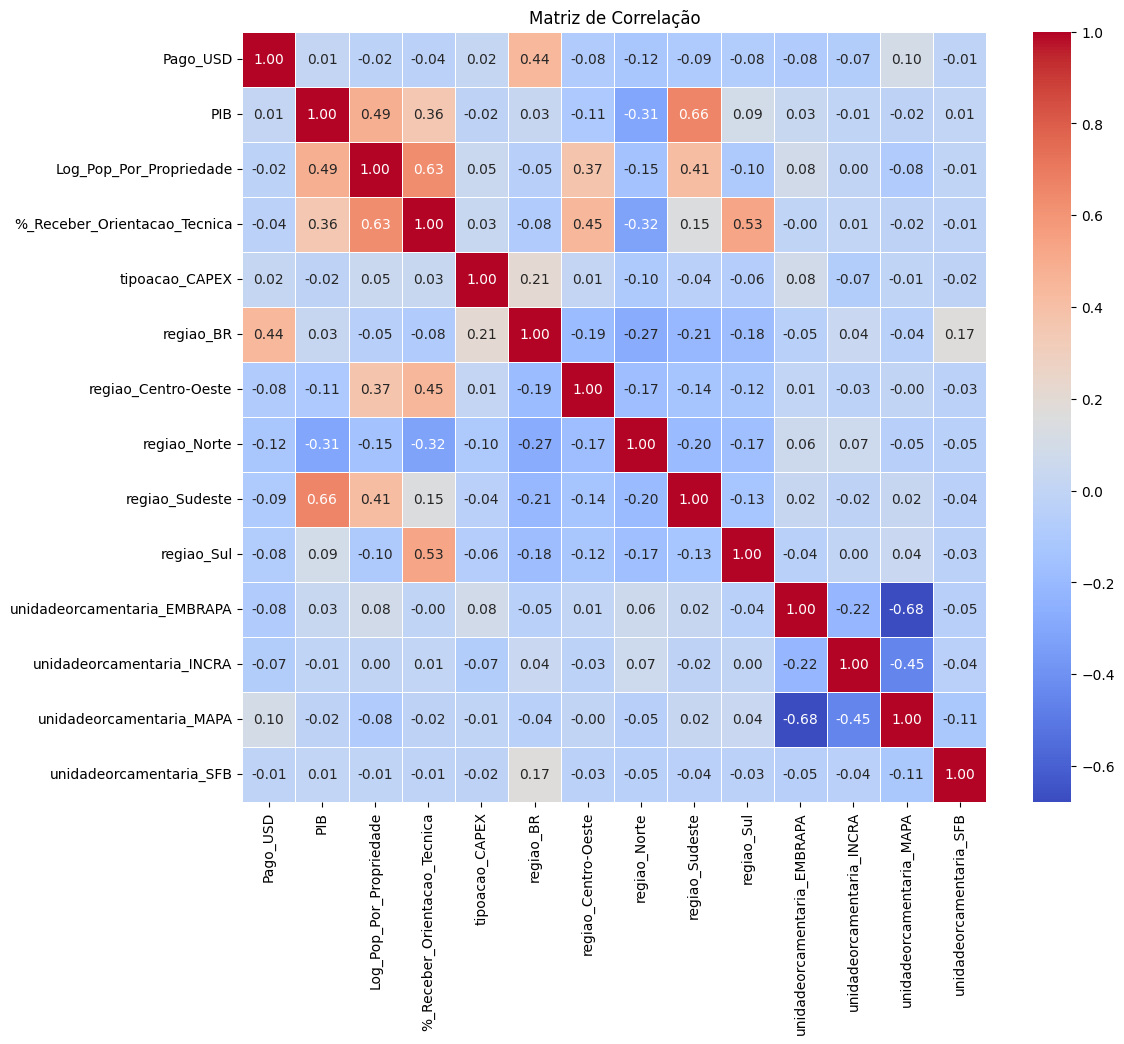

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Carregar o arquivo CSV
file_path = 'C:\\DSA_USP\\DATA_SOURCE\\ANÁLISE FINAL V05.csv'
df = pd.read_csv(file_path, sep=';', decimal=',')

# One-hot encoding para os atributos 'tipoacao', 'regiao' e 'unidadeorcamentaria'
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(df[['tipoacao', 'regiao', 'unidadeorcamentaria']])

# Criar nomes de colunas personalizados
encoded_columns = encoder.get_feature_names_out(['tipoacao', 'regiao', 'unidadeorcamentaria'])

# Criar DataFrame codificado com os nomes de colunas personalizados
df_encoded = pd.DataFrame(encoded_data, columns=encoded_columns, index=df.index)

# Concatenar as colunas codificadas com o DataFrame original
df = pd.concat([df, df_encoded], axis=1)

# Remover as colunas originais 'tipoacao', 'regiao' e 'unidadeorcamentaria'
df = df.drop(['tipoacao', 'regiao', 'unidadeorcamentaria'], axis=1)

# Selecionar as features relevantes
features = [
    'Pago_USD',
    'PIB',
    'Log_Pop_Por_Propriedade',
    '%_Receber_Orientacao_Tecnica',
    'tipoacao_CAPEX',
    'regiao_BR',
    'regiao_Centro-Oeste',
    'regiao_Norte',
    'regiao_Sudeste',
    'regiao_Sul',
     'unidadeorcamentaria_EMBRAPA',
    'unidadeorcamentaria_INCRA',
    'unidadeorcamentaria_MAPA',
    'unidadeorcamentaria_SFB'
]

# Criar o DataFrame com as features selecionadas
df_features = df[features]

# Calcular a matriz de correlação
correlation_matrix = df_features.corr()

# Salvar a matriz de correlação em um arquivo CSV
correlation_matrix.to_excel('C:\\DSA_USP\\DATA_SOURCE\\matriz_correlacao.xlsx', index=False)

# Plotar a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()



In [21]:
!pip install plotly

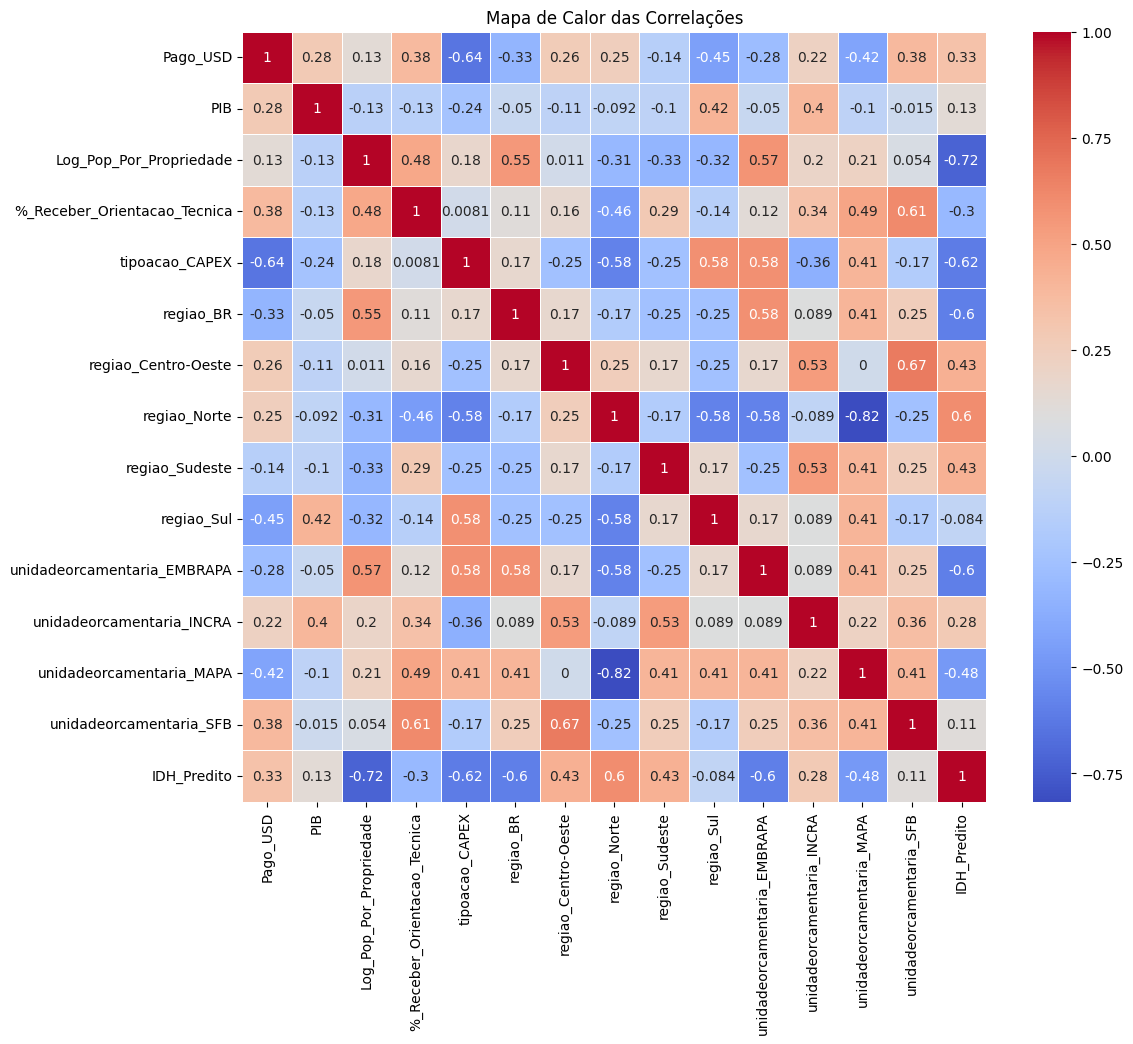

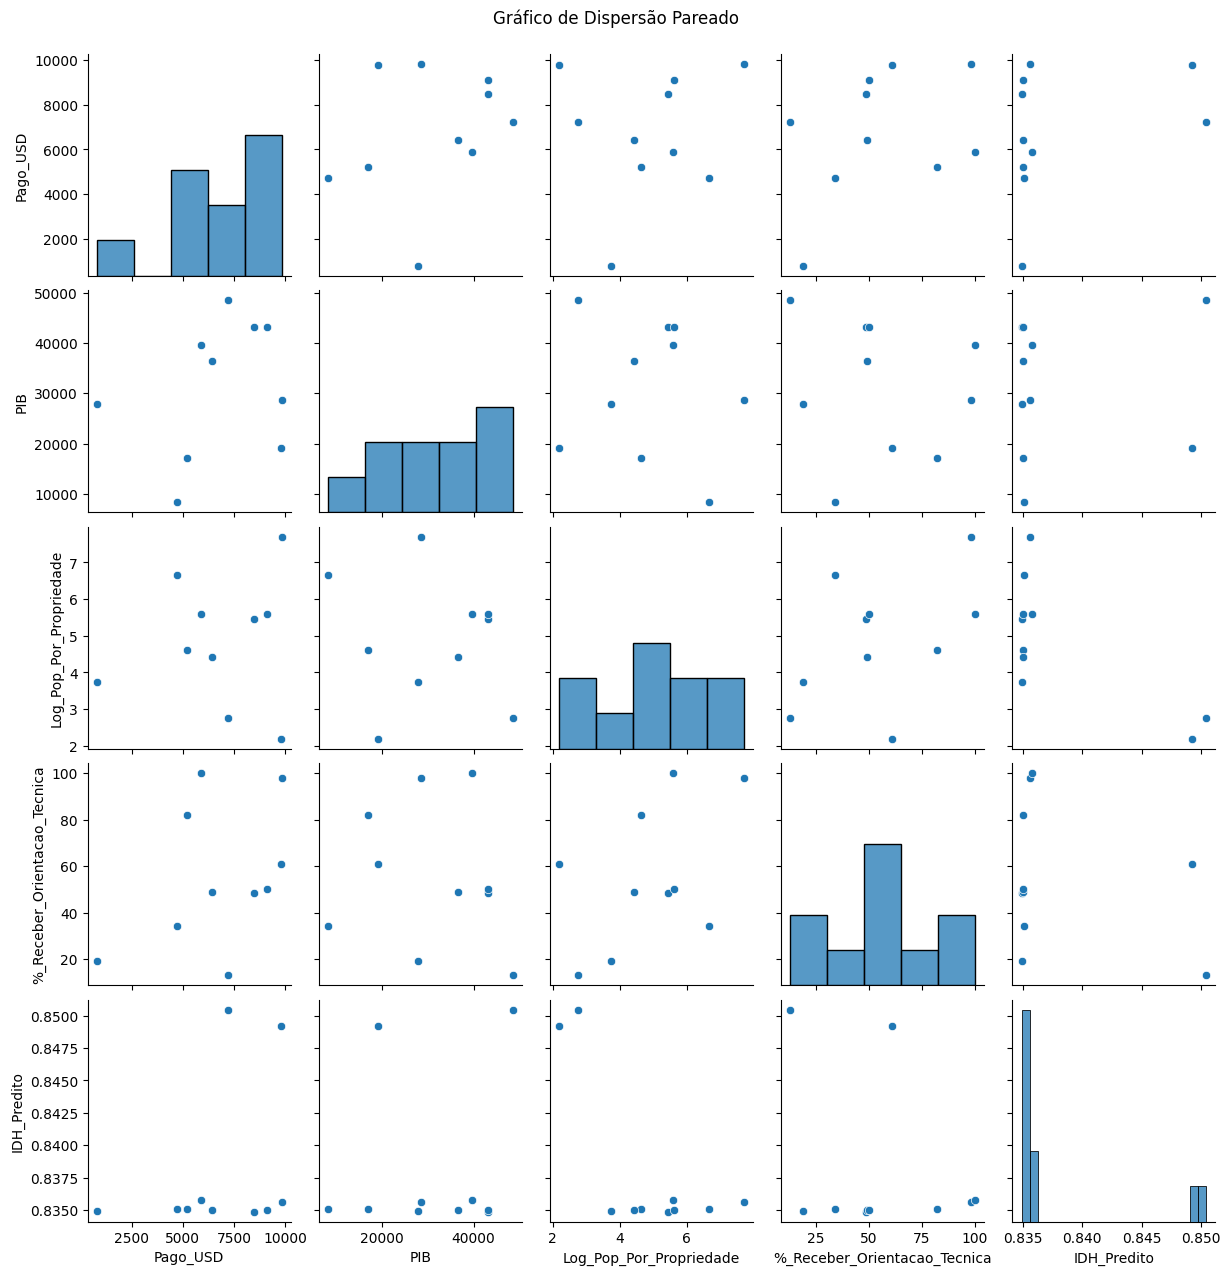

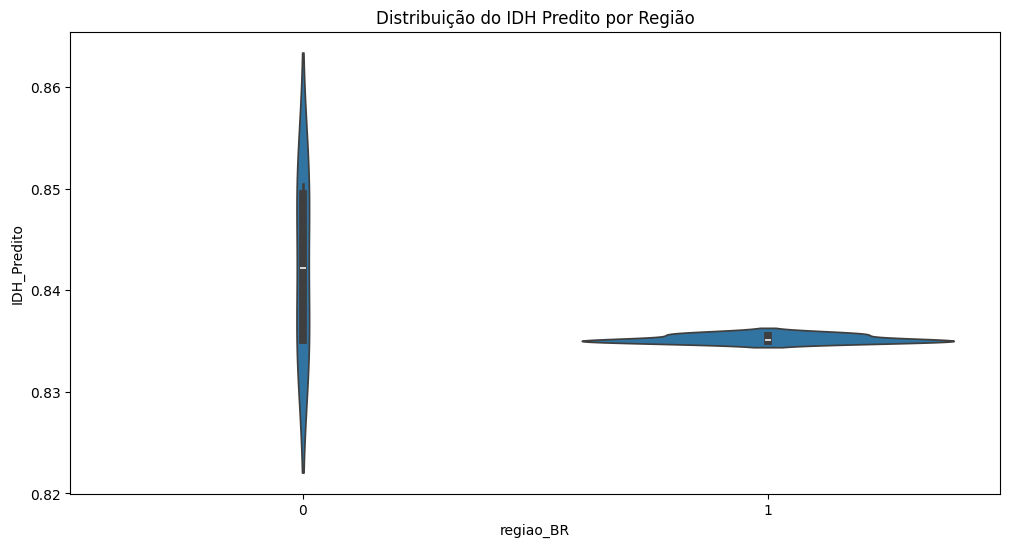

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Assumindo que df_test_base é o seu DataFrame com as predições

# 1. Mapa de calor (Heatmap)
plt.figure(figsize=(12, 10))
sns.heatmap(df_test_base.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de Calor das Correlações')
plt.show()

# 2. Gráfico de dispersão pareado (Paired scatter plot)
sns.pairplot(df_test_base[['Pago_USD', 'PIB', 'Log_Pop_Por_Propriedade', '%_Receber_Orientacao_Tecnica', 'IDH_Predito']])
plt.suptitle('Gráfico de Dispersão Pareado', y=1.02)
plt.show()

# 3. Gráfico de violino (Violin plot)
plt.figure(figsize=(12, 6))
sns.violinplot(x='regiao_BR', y='IDH_Predito', data=df_test_base)
plt.title('Distribuição do IDH Predito por Região')
plt.show()

# 4. Gráfico de dispersão 3D
fig = px.scatter_3d(df_test_base, x='PIB', y='Pago_USD', z='%_Receber_Orientacao_Tecnica',
                    color='IDH_Predito', size='Log_Pop_Por_Propriedade',
                    labels={'IDH_Predito': 'IDH Predito'})
fig.update_layout(title='Gráfico de Dispersão 3D: PIB vs Pago_USD vs %_Receber_Orientacao_Tecnica')
fig.show()

# 5. Gráfico de bolhas (Bubble chart)
fig = px.scatter(df_test_base, x='PIB', y='Pago_USD', size='IDH_Predito', color='regiao_BR',
                 hover_name='regiao_BR', size_max=60)
fig.update_layout(title='Gráfico de Bolhas: PIB vs Pago_USD, tamanho representa IDH Predito')
fig.show()

# 6. Gráfico de linhas para análise temporal (simulado)
# Nota: Como não temos dados temporais reais, vamos simular uma série temporal
df_temporal = pd.DataFrame({
    'Ano': range(2010, 2020),
    'IDH_Predito_BR': np.random.uniform(0.7, 0.8, 10),
    'IDH_Predito_Centro-Oeste': np.random.uniform(0.65, 0.75, 10),
    'IDH_Predito_Norte': np.random.uniform(0.6, 0.7, 10),
    'IDH_Predito_Sudeste': np.random.uniform(0.75, 0.85, 10),
    'IDH_Predito_Sul': np.random.uniform(0.7, 0.8, 10)
})

fig = px.line(df_temporal, x='Ano', y=['IDH_Predito_BR', 'IDH_Predito_Centro-Oeste', 
                                       'IDH_Predito_Norte', 'IDH_Predito_Sudeste', 'IDH_Predito_Sul'])
fig.update_layout(title='Evolução do IDH Predito por Região (Simulado)', xaxis_title='Ano', yaxis_title='IDH Predito')
fig.show()

# 7. Gráfico de radar
# Selecionando algumas variáveis para o gráfico de radar
variables = ['PIB', 'Pago_USD', '%_Receber_Orientacao_Tecnica', 'Log_Pop_Por_Propriedade', 'IDH_Predito']
df_radar = df_test_base[variables].mean().reset_index()
df_radar.columns = ['Variável', 'Valor']

fig = go.Figure()
fig.add_trace(go.Scatterpolar(
    r=df_radar['Valor'],
    theta=df_radar['Variável'],
    fill='toself'
))
fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    showlegend=False,
    title='Gráfico de Radar: Média das Variáveis'
)
fig.show()

# 8. Gráfico de cascata (Waterfall chart)
# Simulando contribuições para o IDH
contribuicoes = {'PIB': 0.3, 'Educação': 0.2, 'Saúde': 0.15, 'Infraestrutura': 0.1, 'Outros': 0.05}
contribuicoes['Total'] = sum(contribuicoes.values())

fig = go.Figure(go.Waterfall(
    name="IDH", orientation="v",
    measure=["relative", "relative", "relative", "relative", "relative", "total"],
    x=list(contribuicoes.keys()),
    y=list(contribuicoes.values()),
    connector={"line":{"color":"rgb(63, 63, 63)"}},
))
fig.update_layout(title="Contribuições para o IDH (Simulado)", showlegend=False)
fig.show()

In [7]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

# Carregar o modelo salvo
with open('C:\\DSA_USP\\DATA_SOURCE\\modelo_idh.pkl', 'rb') as file:
    best_model = pickle.load(file)

# Carregar o scaler salvo
with open('C:\\DSA_USP\\DATA_SOURCE\\scaler_idh.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Gerar massa de teste base
test_data_base = {
    'Pago_USD': np.random.rand(10) * 10000,
    'PIB': np.random.rand(10) * 50000,
    'Log_Pop_Por_Propriedade': np.random.rand(10) * 10,
    '%_Receber_Orientacao_Tecnica': np.random.rand(10) * 100,
    'tipoacao_CAPEX': np.random.randint(0, 2, 10),
    'regiao_BR': np.random.randint(0, 2, 10),
    'regiao_Centro-Oeste': np.random.randint(0, 2, 10),
    'regiao_Norte': np.random.randint(0, 2, 10),
    'regiao_Sudeste': np.random.randint(0, 2, 10),
    'regiao_Sul': np.random.randint(0, 2, 10),
    'unidadeorcamentaria_EMBRAPA': np.random.randint(0, 2, 10),
    'unidadeorcamentaria_INCRA': np.random.randint(0, 2, 10),
    'unidadeorcamentaria_MAPA': np.random.randint(0, 2, 10),
    'unidadeorcamentaria_SFB': np.random.randint(0, 2, 10)
}

df_test_base = pd.DataFrame(test_data_base)

print(df_test_base)

# Aplicar os incrementos desejados
df_test_base['%_Receber_Orientacao_Tecnica'] = df_test_base['%_Receber_Orientacao_Tecnica'].apply(lambda x: min(x + 1, 100))
df_test_base['PIB'] = df_test_base['PIB'] * 1.01

# Selecionar as features relevantes
selected_features = [
    'Pago_USD', 'PIB', 'Log_Pop_Por_Propriedade', '%_Receber_Orientacao_Tecnica',
    'tipoacao_CAPEX', 'regiao_BR', 'regiao_Centro-Oeste', 'regiao_Norte',
    'regiao_Sudeste', 'regiao_Sul', 'unidadeorcamentaria_EMBRAPA',
    'unidadeorcamentaria_INCRA', 'unidadeorcamentaria_MAPA', 'unidadeorcamentaria_SFB'
]

X_test = df_test_base[selected_features]

# Normalizar os dados de teste utilizando o scaler carregado
X_test_scaled = scaler.transform(X_test)

# Fazer previsões
y_pred = best_model.predict(X_test_scaled)

# Resultados das previsões
predictions_df = pd.DataFrame({'IDH_Predito': y_pred})
print(predictions_df)


      Pago_USD           PIB  Log_Pop_Por_Propriedade  \
0  9542.533356   4484.839125                 1.194531   
1  4655.843335  17755.799402                 3.474946   
2  6847.328908   6175.636967                 4.661041   
3  6888.007634  43369.148405                 4.969230   
4  8361.421297  37665.055419                 6.151936   
5  6764.863584  16091.177407                 2.110485   
6  4113.961500  12054.094215                 2.198917   
7  1512.045500  34309.807897                 0.504298   
8  6522.183910  17583.482991                 7.147741   
9  7237.230845   1070.136174                 5.329458   

   %_Receber_Orientacao_Tecnica  tipoacao_CAPEX  regiao_BR  \
0                      5.603778               0          0   
1                     46.173605               0          0   
2                     70.085559               0          1   
3                      4.654651               0          1   
4                     50.258108               0          0   


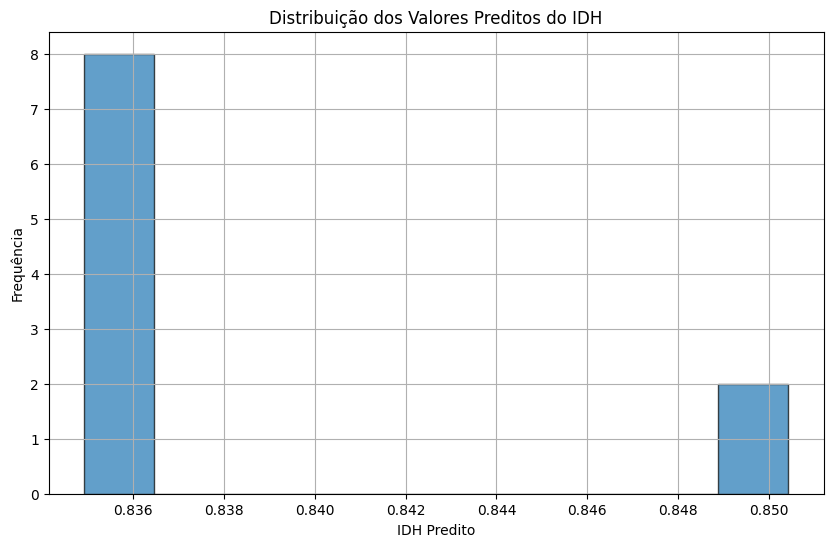

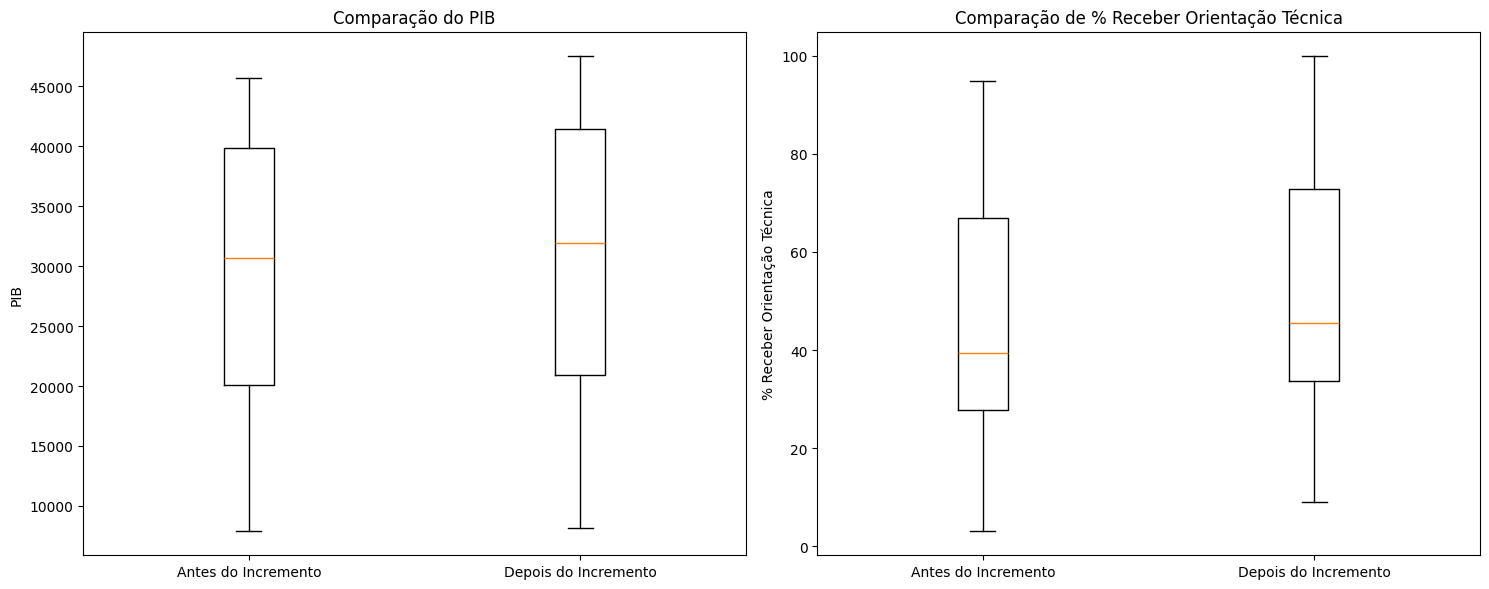

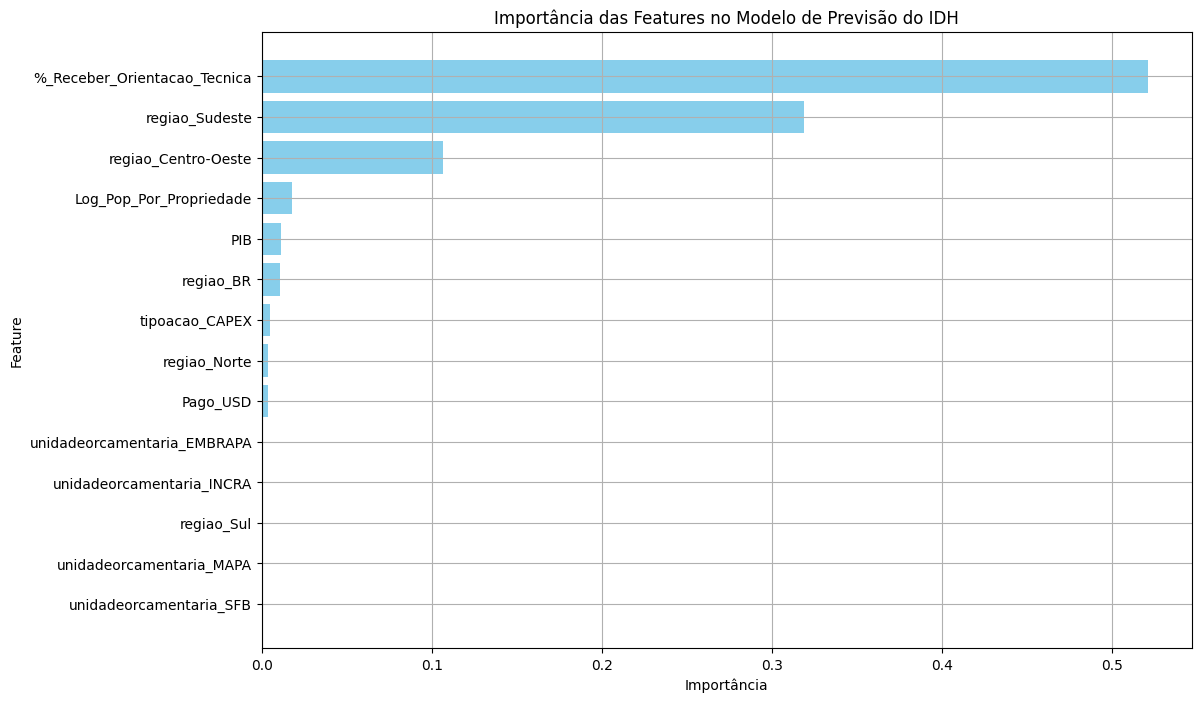

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Dados preditos do IDH
idh_predito = [0.834910, 0.835075, 0.849206, 0.835010, 0.834958, 0.835614, 0.835010, 0.835129, 0.850434, 0.835780]
predictions_df = pd.DataFrame({'IDH_Predito': idh_predito})

# Massa de teste base e com incrementos
test_data_base = {
    'Pago_USD': [8469.768771, 5192.971209, 9791.965006, 6444.357776, 795.589774, 9835.473427, 9130.503738, 4723.404812, 7219.911737, 5908.988180],
    'PIB': [41935.314380, 16555.573266, 18598.049493, 35461.428423, 27077.723030, 27782.149372, 41970.803178, 8101.764676, 47103.523890, 38504.144488],
    'Log_Pop_Por_Propriedade': [5.446376, 4.622082, 2.198655, 4.411882, 3.729509, 7.695662, 5.604022, 6.645694, 2.757718, 5.600078],
    '%_Receber_Orientacao_Tecnica': [43.631972, 77.085489, 56.104011, 43.936359, 13.929682, 92.944800, 44.943570, 29.073433, 8.056857, 99.922796],
    'tipoacao_CAPEX': [0, 1, 0, 1, 1, 0, 1, 1, 0, 1],
    'regiao_BR': [1, 0, 0, 1, 1, 1, 0, 1, 0, 1],
    'regiao_Centro-Oeste': [0, 0, 1, 1, 0, 1, 0, 1, 1, 1],
    'regiao_Norte': [1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
    'regiao_Sudeste': [0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
    'regiao_Sul': [0, 1, 0, 1, 1, 0, 1, 0, 1, 1],
    'unidadeorcamentaria_EMBRAPA': [0, 0, 0, 1, 1, 1, 1, 1, 0, 1],
    'unidadeorcamentaria_INCRA': [0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
    'unidadeorcamentaria_MAPA': [0, 1, 0, 1, 1, 1, 0, 0, 0, 1],
    'unidadeorcamentaria_SFB': [0, 0, 1, 1, 0, 1, 0, 0, 0, 1]
}

df_test_base = pd.DataFrame(test_data_base)

# Aplicar os incrementos desejados
df_test_base['%_Receber_Orientacao_Tecnica'] = df_test_base['%_Receber_Orientacao_Tecnica'].apply(lambda x: min(x + 1, 100))
df_test_base['PIB'] = df_test_base['PIB'] * 1.01

# Carregar o modelo salvo
with open('C:\\DSA_USP\\DATA_SOURCE\\modelo_idh.pkl', 'rb') as file:
    best_model = pickle.load(file)

# Carregar o scaler salvo
with open('C:\\DSA_USP\\DATA_SOURCE\\scaler_idh.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Selecionar as features relevantes
selected_features = [
    'Pago_USD', 'PIB', 'Log_Pop_Por_Propriedade', '%_Receber_Orientacao_Tecnica',
    'tipoacao_CAPEX', 'regiao_BR', 'regiao_Centro-Oeste', 'regiao_Norte',
    'regiao_Sudeste', 'regiao_Sul', 'unidadeorcamentaria_EMBRAPA',
    'unidadeorcamentaria_INCRA', 'unidadeorcamentaria_MAPA', 'unidadeorcamentaria_SFB'
]

X_test = df_test_base[selected_features]

# Normalizar os dados de teste utilizando o scaler carregado
X_test_scaled = scaler.transform(X_test)

# Fazer previsões
y_pred = best_model.predict(X_test_scaled)

# Adicionar as previsões ao DataFrame
df_test_base['IDH_Predito'] = y_pred

# Gráfico 1: Distribuição dos valores preditos do IDH
plt.figure(figsize=(10, 6))
plt.hist(df_test_base['IDH_Predito'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribuição dos Valores Preditos do IDH')
plt.xlabel('IDH Predito')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

# Gerar massa de teste base sem incrementos para comparação
test_data_no_increment = pd.DataFrame(test_data_base)
test_data_no_increment['%_Receber_Orientacao_Tecnica'] -= 5
test_data_no_increment['PIB'] /= 1.03

# Gráfico 2: Comparação das variáveis principais antes e depois dos incrementos
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# PIB
axs[0].boxplot([test_data_no_increment['PIB'], df_test_base['PIB']], labels=['Antes do Incremento', 'Depois do Incremento'])
axs[0].set_title('Comparação do PIB')
axs[0].set_ylabel('PIB')

# % Receber Orientação Técnica
axs[1].boxplot([test_data_no_increment['%_Receber_Orientacao_Tecnica'], df_test_base['%_Receber_Orientacao_Tecnica']], labels=['Antes do Incremento', 'Depois do Incremento'])
axs[1].set_title('Comparação de % Receber Orientação Técnica')
axs[1].set_ylabel('% Receber Orientação Técnica')

plt.tight_layout()
plt.show()

# Gráfico 3: Importância das features utilizadas no modelo
feature_importances = best_model.feature_importances_
features = selected_features

# Criar DataFrame para as importâncias
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plotar importâncias das features
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Importância das Features no Modelo de Previsão do IDH')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()



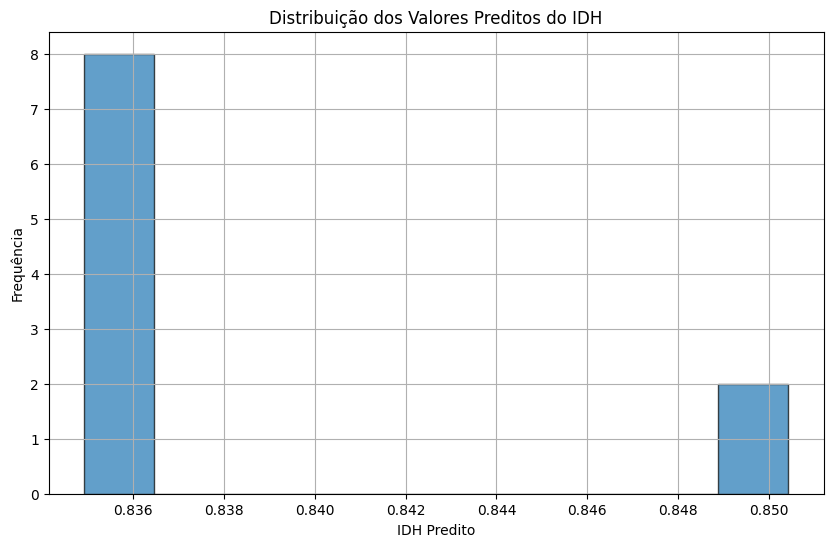

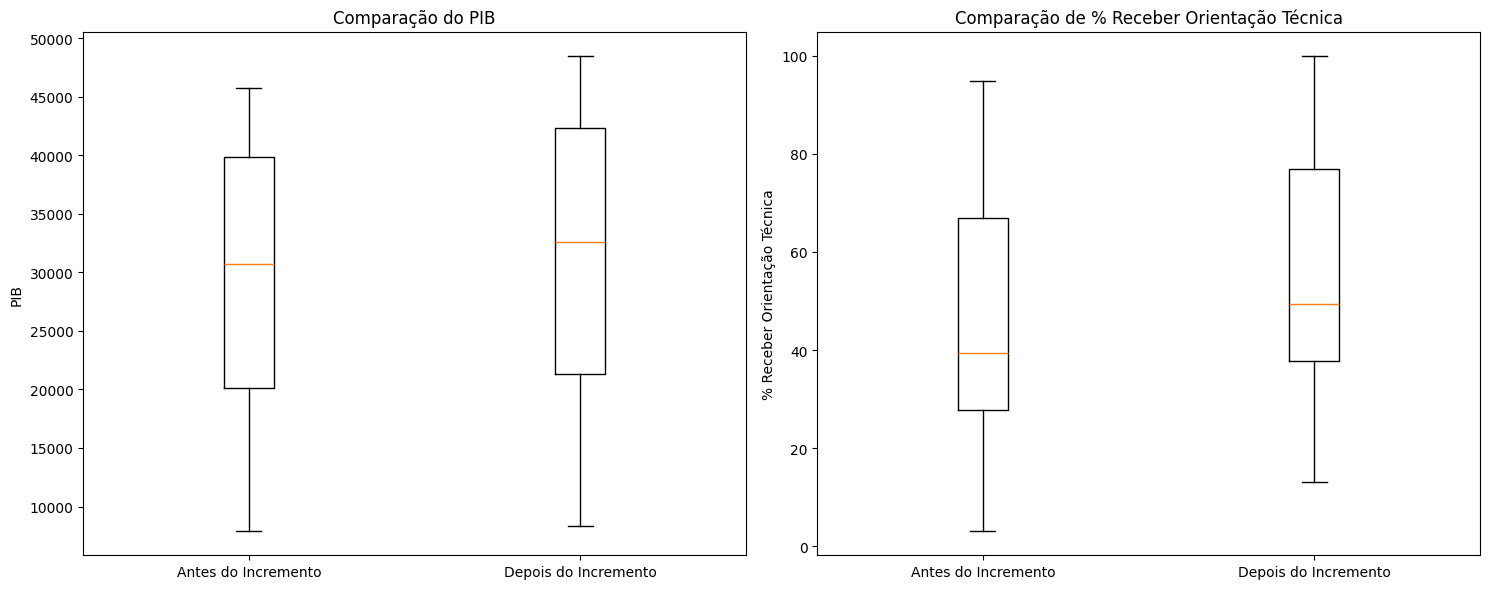

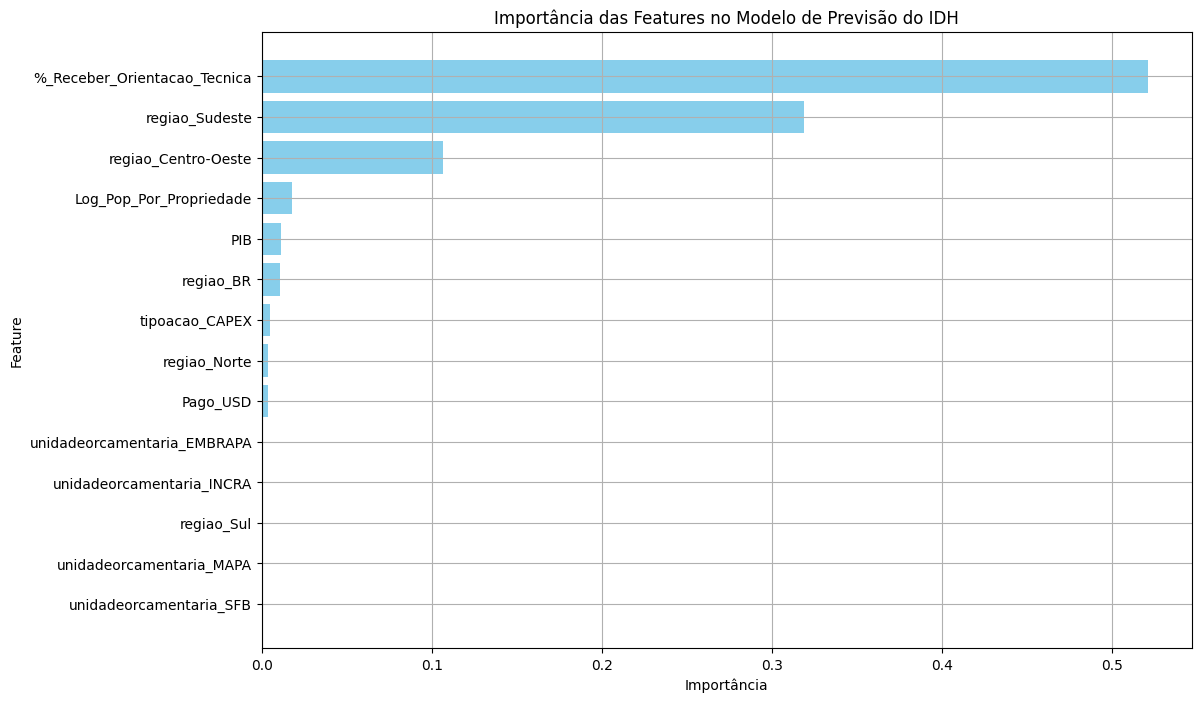

In [10]:
import matplotlib.pyplot as plt

# Carregar o modelo salvo
with open('C:\\DSA_USP\\DATA_SOURCE\\modelo_idh.pkl', 'rb') as file:
    best_model = pickle.load(file)

# Carregar o scaler salvo
with open('C:\\DSA_USP\\DATA_SOURCE\\scaler_idh.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Gerar massa de teste base
test_data_base = {
    'Pago_USD': [8469.768771, 5192.971209, 9791.965006, 6444.357776, 795.589774, 9835.473427, 9130.503738, 4723.404812, 7219.911737, 5908.988180],
    'PIB': [41935.314380, 16555.573266, 18598.049493, 35461.428423, 27077.723030, 27782.149372, 41970.803178, 8101.764676, 47103.523890, 38504.144488],
    'Log_Pop_Por_Propriedade': [5.446376, 4.622082, 2.198655, 4.411882, 3.729509, 7.695662, 5.604022, 6.645694, 2.757718, 5.600078],
    '%_Receber_Orientacao_Tecnica': [43.631972, 77.085489, 56.104011, 43.936359, 13.929682, 92.944800, 44.943570, 29.073433, 8.056857, 99.922796],
    'tipoacao_CAPEX': [0, 1, 0, 1, 1, 0, 1, 1, 0, 1],
    'regiao_BR': [1, 0, 0, 1, 1, 1, 0, 1, 0, 1],
    'regiao_Centro-Oeste': [0, 0, 1, 1, 0, 1, 0, 1, 1, 1],
    'regiao_Norte': [1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
    'regiao_Sudeste': [0, 1, 1, 0, 1, 1, 0, 0, 1, 1],
    'regiao_Sul': [0, 1, 0, 1, 1, 0, 1, 0, 1, 1],
    'unidadeorcamentaria_EMBRAPA': [0, 0, 0, 1, 1, 1, 1, 1, 0, 1],
    'unidadeorcamentaria_INCRA': [0, 0, 0, 0, 0, 1, 0, 0, 1, 1],
    'unidadeorcamentaria_MAPA': [0, 1, 0, 1, 1, 1, 0, 0, 0, 1],
    'unidadeorcamentaria_SFB': [0, 0, 1, 1, 0, 1, 0, 0, 0, 1]
}

df_test_base = pd.DataFrame(test_data_base)

# Aplicar os incrementos desejados
df_test_base['%_Receber_Orientacao_Tecnica'] = df_test_base['%_Receber_Orientacao_Tecnica'].apply(lambda x: min(x + 5, 100))
df_test_base['PIB'] = df_test_base['PIB'] * 1.03

# Selecionar as features relevantes
selected_features = [
    'Pago_USD', 'PIB', 'Log_Pop_Por_Propriedade', '%_Receber_Orientacao_Tecnica',
    'tipoacao_CAPEX', 'regiao_BR', 'regiao_Centro-Oeste', 'regiao_Norte',
    'regiao_Sudeste', 'regiao_Sul', 'unidadeorcamentaria_EMBRAPA',
    'unidadeorcamentaria_INCRA', 'unidadeorcamentaria_MAPA', 'unidadeorcamentaria_SFB'
]

X_test = df_test_base[selected_features]

# Normalizar os dados de teste utilizando o scaler carregado
X_test_scaled = scaler.transform(X_test)

# Fazer previsões
y_pred = best_model.predict(X_test_scaled)

# Adicionar as previsões ao DataFrame
df_test_base['IDH_Predito'] = y_pred

# Gráfico 1: Distribuição dos valores preditos do IDH
plt.figure(figsize=(10, 6))
plt.hist(df_test_base['IDH_Predito'], bins=10, edgecolor='k', alpha=0.7)
plt.title('Distribuição dos Valores Preditos do IDH')
plt.xlabel('IDH Predito')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

# Gerar massa de teste base sem incrementos para comparação
test_data_no_increment = pd.DataFrame(test_data_base)
test_data_no_increment['%_Receber_Orientacao_Tecnica'] -= 5
test_data_no_increment['PIB'] /= 1.03

# Gráfico 2: Comparação das variáveis principais antes e depois dos incrementos
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# PIB
axs[0].boxplot([test_data_no_increment['PIB'], df_test_base['PIB']], labels=['Antes do Incremento', 'Depois do Incremento'])
axs[0].set_title('Comparação do PIB')
axs[0].set_ylabel('PIB')

# % Receber Orientação Técnica
axs[1].boxplot([test_data_no_increment['%_Receber_Orientacao_Tecnica'], df_test_base['%_Receber_Orientacao_Tecnica']], labels=['Antes do Incremento', 'Depois do Incremento'])
axs[1].set_title('Comparação de % Receber Orientação Técnica')
axs[1].set_ylabel('% Receber Orientação Técnica')

plt.tight_layout()
plt.show()

# Gráfico 3: Importância das features utilizadas no modelo
feature_importances = best_model.feature_importances_
features = selected_features

# Criar DataFrame para as importâncias
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plotar importâncias das features
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Importância das Features no Modelo de Previsão do IDH')
plt.xlabel('Importância')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()



 Ano  IDH Projetado
2024       0.756073
2025       0.758043
2026       0.760018
2027       0.761998
2028       0.763984
2029       0.765974
2030       0.767970
2031       0.769971
2032       0.771977
2033       0.773988
2034       0.776005


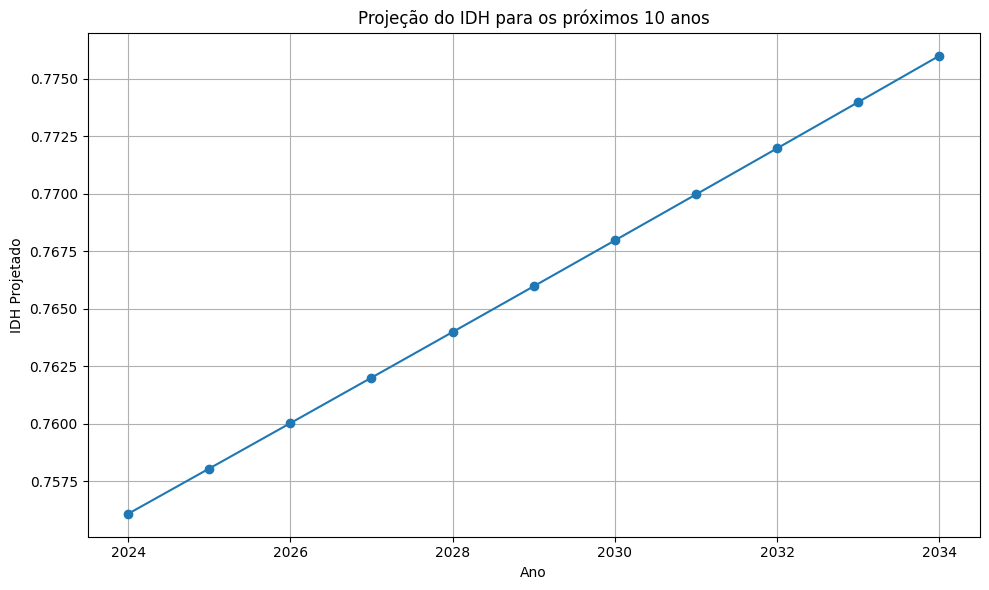

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_idh_impact(current_idh, importance, change, years):
    idh_values = [current_idh]
    
    for _ in range(years):
        delta_idh = current_idh * (importance * change)
        current_idh += delta_idh
        idh_values.append(current_idh)
    
    return idh_values

# Parâmetros iniciais
initial_idh = 0.756073118 # IDH médio no período
importance = 0.521084  # Importância da variável %_Receber_Orientacao_Tecnica
annual_change = 0.005  # 1 ponto percentual
years = 10

# Cálculo da projeção
idh_projection = calculate_idh_impact(initial_idh, importance, annual_change, years)

# Criação do DataFrame
df = pd.DataFrame({
    'Ano': range(2024, 2024 + years + 1),
    'IDH Projetado': idh_projection
})

# Exibição dos resultados
print(df.to_string(index=False))

# Visualização gráfica
plt.figure(figsize=(10, 6))
plt.plot(df['Ano'], df['IDH Projetado'], marker='o')
plt.title('Projeção do IDH para os próximos 10 anos')
plt.xlabel('Ano')
plt.ylabel('IDH Projetado')
plt.grid(True)
plt.tight_layout()
plt.show()